In [20]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Set seeds
torch.manual_seed(42)
np.random.seed(42)

In [48]:
csv_file = "homeworks/AGENCY.csv" 
df = pd.read_csv(csv_file)

# Extract pixels and labels
pixel_cols = [f'r{i}c{j}' for i in range(20) for j in range(20)]
X = df[pixel_cols].values.reshape(-1, 20, 20).astype(np.float32) / 255.0
unicode_labels = df['m_label'].values

# Map unicode to indices
unique_labels = sorted(set(unicode_labels))
label_map = {label: i for i, label in enumerate(unique_labels)}
Y = np.array([label_map[label] for label in unicode_labels])

num_classes = len(unique_labels)
print(f"Loaded {len(X)} samples with {num_classes} classes")


Loaded 1004 samples with 251 classes


In [35]:
X_tensor = torch.FloatTensor(X).unsqueeze(1)
Y_tensor = torch.LongTensor(Y)

X_train, X_test, Y_train, Y_test = train_test_split(X_tensor, Y_tensor, test_size=0.2, random_state=42)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.2, random_state=42)

train_loader = DataLoader(TensorDataset(X_train, Y_train), batch_size=64, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val, Y_val), batch_size=64, shuffle=False)
test_loader = DataLoader(TensorDataset(X_test, Y_test), batch_size=64, shuffle=False)

## basic CNN Models

In [36]:
class BasicCNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(64*5*5, 128)
        self.fc2 = nn.Linear(128, num_classes)
        self.dropout = nn.Dropout(0.5)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64*5*5)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        return self.fc2(x)

In [37]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = BasicCNN(num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

print("Training Basic CNN...")
for epoch in range(15):
    model.train()
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    
    # Validation
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    val_acc = 100 * correct / total
    print(f'Epoch {epoch+1}: Val Accuracy = {val_acc:.2f}%')

Training Basic CNN...
Epoch 1: Val Accuracy = 0.00%
Epoch 2: Val Accuracy = 0.00%
Epoch 3: Val Accuracy = 0.00%
Epoch 4: Val Accuracy = 0.00%
Epoch 5: Val Accuracy = 0.00%
Epoch 6: Val Accuracy = 0.00%
Epoch 7: Val Accuracy = 0.00%
Epoch 8: Val Accuracy = 0.62%
Epoch 9: Val Accuracy = 0.00%
Epoch 10: Val Accuracy = 0.62%
Epoch 11: Val Accuracy = 0.62%
Epoch 12: Val Accuracy = 1.24%
Epoch 13: Val Accuracy = 1.86%
Epoch 14: Val Accuracy = 4.35%
Epoch 15: Val Accuracy = 8.07%


In [38]:
# Test Basic Model
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

basic_acc = 100 * correct / total
print(f'Basic CNN Test Accuracy: {basic_acc:.2f}%')


Basic CNN Test Accuracy: 5.47%


## Improved Model

In [39]:
class ImprovedCNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(128*5*5, 256)
        self.fc2 = nn.Linear(256, num_classes)
        self.dropout = nn.Dropout(0.5)
        
    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = F.relu(self.bn3(self.conv3(x)))
        x = x.view(-1, 128*5*5)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        return self.fc2(x)

In [40]:

# Train Improved Model
improved_model = ImprovedCNN(num_classes).to(device)
optimizer2 = optim.Adam(improved_model.parameters(), lr=0.001)

print("\nTraining Improved CNN...")
for epoch in range(15):
    improved_model.train()
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer2.zero_grad()
        outputs = improved_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer2.step()
    
    # Validation
    improved_model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = improved_model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    val_acc = 100 * correct / total
    print(f'Epoch {epoch+1}: Val Accuracy = {val_acc:.2f}%')

# Test Improved Model
improved_model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = improved_model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

improved_acc = 100 * correct / total
print(f'Improved CNN Test Accuracy: {improved_acc:.2f}%')


Training Improved CNN...
Epoch 1: Val Accuracy = 0.62%
Epoch 2: Val Accuracy = 0.00%
Epoch 3: Val Accuracy = 4.35%
Epoch 4: Val Accuracy = 4.35%
Epoch 5: Val Accuracy = 8.07%
Epoch 6: Val Accuracy = 11.80%
Epoch 7: Val Accuracy = 17.39%
Epoch 8: Val Accuracy = 19.88%
Epoch 9: Val Accuracy = 22.36%
Epoch 10: Val Accuracy = 23.60%
Epoch 11: Val Accuracy = 31.06%
Epoch 12: Val Accuracy = 31.68%
Epoch 13: Val Accuracy = 36.02%
Epoch 14: Val Accuracy = 35.40%
Epoch 15: Val Accuracy = 42.86%
Improved CNN Test Accuracy: 34.83%


In [41]:
class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        # Encoder
        self.enc1 = nn.Conv2d(1, 32, 3, padding=1)
        self.enc2 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2)
        # Decoder
        self.dec1 = nn.ConvTranspose2d(64, 32, 2, stride=2)
        self.dec2 = nn.ConvTranspose2d(32, 1, 2, stride=2)
        
    def forward(self, x):
        x = self.pool(F.relu(self.enc1(x)))
        x = self.pool(F.relu(self.enc2(x)))
        x = F.relu(self.dec1(x))
        return torch.sigmoid(self.dec2(x))

# Train Autoencoder
autoencoder = Autoencoder().to(device)
ae_optimizer = optim.Adam(autoencoder.parameters(), lr=0.001)
mse_loss = nn.MSELoss()

print("\nTraining Autoencoder...")
for epoch in range(10):
    autoencoder.train()
    for inputs, _ in train_loader:
        inputs = inputs.to(device)
        
        # Add noise
        noise = torch.randn_like(inputs) * 0.3
        noisy_inputs = torch.clamp(inputs + noise, 0, 1)
        
        ae_optimizer.zero_grad()
        outputs = autoencoder(noisy_inputs)
        loss = mse_loss(outputs, inputs)
        loss.backward()
        ae_optimizer.step()
    
    print(f'Autoencoder Epoch {epoch+1} completed')



Training Autoencoder...
Autoencoder Epoch 1 completed
Autoencoder Epoch 2 completed
Autoencoder Epoch 3 completed
Autoencoder Epoch 4 completed
Autoencoder Epoch 5 completed
Autoencoder Epoch 6 completed
Autoencoder Epoch 7 completed
Autoencoder Epoch 8 completed
Autoencoder Epoch 9 completed
Autoencoder Epoch 10 completed


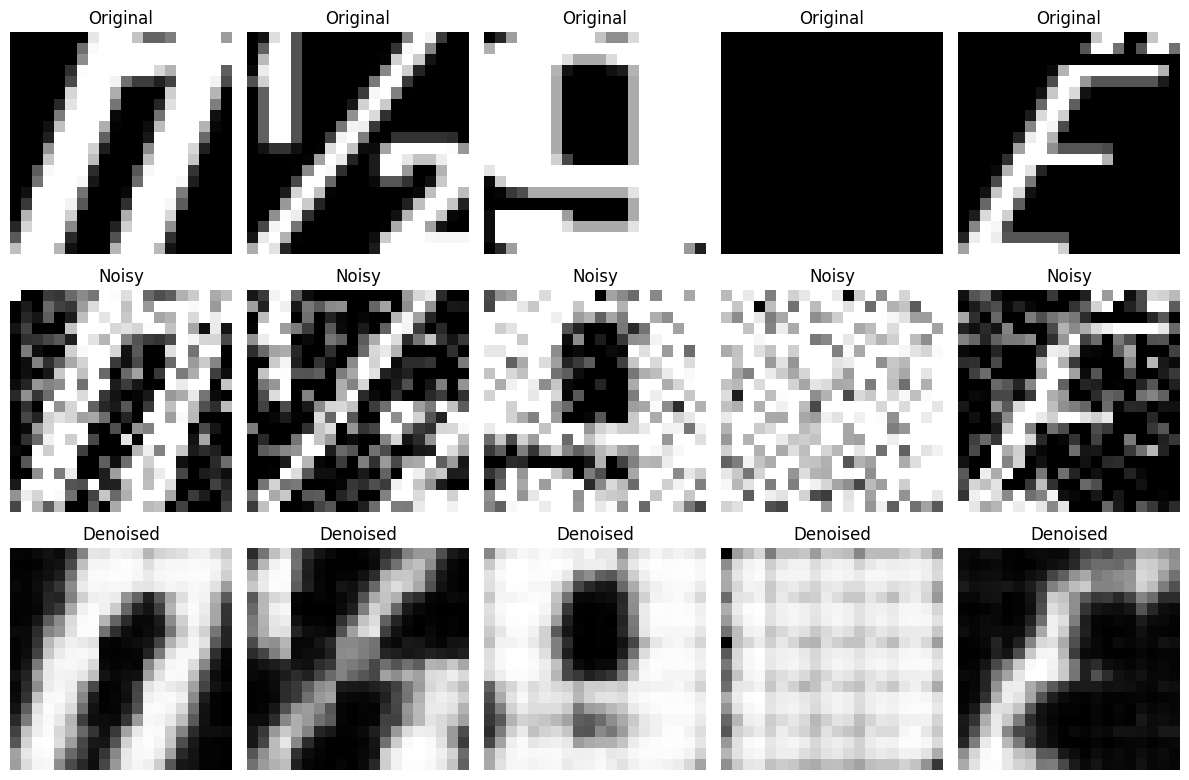

In [47]:

# Test denoising
autoencoder.eval()
test_sample = X_test[:5].to(device)
noise = torch.randn_like(test_sample) * 0.3
noisy_sample = torch.clamp(test_sample + noise, 0, 1)

with torch.no_grad():
    denoised = autoencoder(noisy_sample)

# Plot results
fig, axes = plt.subplots(3, 5, figsize=(12, 8))
for i in range(5):
    axes[0, i].imshow(test_sample[i].squeeze().cpu(), cmap='gray')
    axes[0, i].set_title('Original')
    axes[0, i].axis('off')
    
    axes[1, i].imshow(noisy_sample[i].squeeze().cpu(), cmap='gray')
    axes[1, i].set_title('Noisy')
    axes[1, i].axis('off')
    
    axes[2, i].imshow(denoised[i].squeeze().cpu(), cmap='gray')
    axes[2, i].set_title('Denoised')
    axes[2, i].axis('off')

plt.tight_layout()
plt.show()


In [46]:
# RESULTS 
print(f"Basic CNN Test Accuracy: {basic_acc:.2f}%")
print(f"Improved CNN Test Accuracy:{improved_acc:.2f}%")
print(f"Improvement:{improved_acc - basic_acc:.2f}%")


Basic CNN Test Accuracy: 5.47%
Improved CNN Test Accuracy:34.83%
Improvement:29.35%


## exploration and evaluation

In [55]:
def test_different_csv(csv_file, model, original_label_map):
    try:
        df_new = pd.read_csv(csv_file)
        
        # Extract pixels
        pixel_cols = [f'r{i}c{j}' for i in range(20) for j in range(20)]
        X_new = df_new[pixel_cols].values.reshape(-1, 20, 20).astype(np.float32) / 255.0
        
        # Extract labels and filter
        unicode_new = df_new['m_label'].values
        valid_samples = []
        valid_labels = []
        
        for i, unicode_val in enumerate(unicode_new):
            if unicode_val in original_label_map:
                valid_samples.append(i)
                valid_labels.append(original_label_map[unicode_val])
        
        if len(valid_samples) == 0:
            print(f"   No matching characters found in {csv_file}")
            return 0.0
        
        #subset
        max_test = min(1000, len(valid_samples))
        indices = np.random.choice(valid_samples, max_test, replace=False)
        
        X_test_new = X_new[indices]
        Y_test_new = np.array([original_label_map[unicode_new[i]] for i in indices])
        
        #Test the model
        X_tensor = torch.FloatTensor(X_test_new).unsqueeze(1).to(device)
        Y_tensor = torch.LongTensor(Y_test_new).to(device)
        
        model.eval()
        with torch.no_grad():
            outputs = model(X_tensor)
            _, predicted = torch.max(outputs, 1)
            accuracy = (predicted == Y_tensor).float().mean() * 100
        
        print(f"   Tested on {max_test} samples from {csv_file}")
        print(f"   Accuracy: {accuracy:.2f}%")
        return accuracy.item()
        
    except Exception as e:
        return 0.0

# different CSV file
other_fonts = ["homeworks/ARIAL.csv", "homeworks/BELL.csv"]
cross_font_results = {}

for font_file in other_fonts:
    if font_file != csv_file:  
        acc = test_different_csv(font_file, improved_model, label_map)
        if acc > 0:
            cross_font_results[font_file] = acc
            break  

#MULTI-FONT TRAINING
def load_second_csv(csv_file, original_label_map, max_samples=2000):
    try:
        df2 = pd.read_csv(csv_file)
        
        pixel_cols = [f'r{i}c{j}' for i in range(20) for j in range(20)]
        X2 = df2[pixel_cols].values.reshape(-1, 20, 20).astype(np.float32) / 255.0
        unicode2 = df2['m_label'].values
        
        # Filter to known characters
        valid_X = []
        valid_Y = []
        for i, unicode_val in enumerate(unicode2):
            if unicode_val in original_label_map:
                valid_X.append(X2[i])
                valid_Y.append(original_label_map[unicode_val])
        
        if len(valid_X) == 0:
            return None, None
        
        valid_X = np.array(valid_X)
        valid_Y = np.array(valid_Y)
        
        # Limit samples
        if len(valid_X) > max_samples:
            indices = np.random.choice(len(valid_X), max_samples, replace=False)
            valid_X = valid_X[indices]
            valid_Y = valid_Y[indices]
        
        print(f"   Added {len(valid_X)} samples from {csv_file}")
        return valid_X, valid_Y
        
    except:
        return None, None

#load second font
second_X, second_Y = None, None
for font_file in other_fonts:
    second_X, second_Y = load_second_csv(font_file, label_map)
    if second_X is not None:
        break

if second_X is not None:
    # Combine datasets
    X_combined = np.concatenate([X, second_X])
    Y_combined = np.concatenate([Y, second_Y])
    
    #Train/test split
    X_multi_train, X_multi_test, Y_multi_train, Y_multi_test = train_test_split(
        X_combined, Y_combined, test_size=0.2, random_state=42
    )
    
    #Create data loader
    multi_train_loader = DataLoader(
        TensorDataset(
            torch.FloatTensor(X_multi_train).unsqueeze(1),
            torch.LongTensor(Y_multi_train)
        ), 
        batch_size=64, shuffle=True
    )
    
    #Train multi-font model
    multi_model = BasicCNN(num_classes).to(device)
    optimizer_multi = optim.Adam(multi_model.parameters(), lr=0.01)
    
    for epoch in range(10):
        multi_model.train()
        for inputs, labels in multi_train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer_multi.zero_grad()
            outputs = multi_model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer_multi.step()
        if (epoch + 1) % 5 == 0:
            print(f" Epoch {epoch+1} completed")
    
    # Test multi-font model
    X_test_tensor = torch.FloatTensor(X_multi_test).unsqueeze(1).to(device)
    Y_test_tensor = torch.LongTensor(Y_multi_test).to(device)
    
    multi_model.eval()
    with torch.no_grad():
        outputs = multi_model(X_test_tensor)
        _, predicted = torch.max(outputs, 1)
        multi_acc = (predicted == Y_test_tensor).float().mean() * 100
    
    print(f" Multi-font model accuracy: {multi_acc:.2f}%")
else:
    print("0")
    multi_acc = 0


# Analyze errors on original test set
improved_model.eval()
with torch.no_grad():
    test_outputs = improved_model(X_test[:200].to(device))
    _, test_preds = torch.max(test_outputs, 1)
    test_true = Y_test[:200].to(device)

errors = (test_preds != test_true)
error_count = errors.sum().item()
print(f"Errors: {error_count}/200 samples ({error_count/2:.1f}%)")

# Show some misclassified examples
if error_count > 0:
    error_indices = errors.nonzero().flatten()[:3]
    print("Sample misclassifications:")
    
    for i, idx in enumerate(error_indices):
        true_unicode = unique_labels[test_true[idx].item()]
        pred_unicode = unique_labels[test_preds[idx].item()]
        
        true_char = chr(true_unicode) if true_unicode < 128 else f"U+{true_unicode:04X}"
        pred_char = chr(pred_unicode) if pred_unicode < 128 else f"U+{pred_unicode:04X}"
        
        print(f"{i+1}. True: '{true_char}' → Predicted: '{pred_char}'")


print(f"Original font (single):    {improved_acc:.2f}%")

if cross_font_results:
    for font_file, acc in cross_font_results.items():
        font_name = font_file.replace('.csv', '')
        print(f"Cross-font test ({font_name}):    {acc:.2f}%")

if multi_acc > 0:
    print(f"Multi-font training:       {multi_acc:.2f}%")

print(f"Error rate:                {error_count/2:.1f}%")

   Tested on 1000 samples from homeworks/ARIAL.csv
   Accuracy: 23.70%
   Added 2000 samples from homeworks/ARIAL.csv
 Epoch 5 completed
 Epoch 10 completed
 Multi-font model accuracy: 70.38%
Errors: 130/200 samples (65.0%)
Sample misclassifications:
1. True: 'g' → Predicted: 'U+00BA'
2. True: 'U+2219' → Predicted: 'U+2014'
3. True: 'U+00CB' → Predicted: 'U+00C9'
Original font (single):    34.83%
Cross-font test (homeworks/ARIAL):    23.70%
Multi-font training:       70.38%
Error rate:                65.0%
